# CASA -> XDS image demo
The current authoritative version of the full image XDS 
schema can be found at https://docs.google.com/spreadsheets/d/1WW0Gl6z85cJVPgtdgW4dxucurHFa06OKGjgoK8OREFA/edit#gid=1719181934

**Imports**

In [1]:
from importlib.metadata import version
import os

try:
    import xradio
    print('XRADIO version', version('xradio'), 'already installed.')
except ImportError as e:
    print(e)
    print('Installing XRADIO')

    os.system("pip install xradio")

    import xradio
    print('xradio version', version('xradio'), ' installed.')

from xradio.data.datasets import download
# These are the three API functions that are currently supported
from xradio.image import load_image, read_image, write_image

XRADIO version 0.0.5 already installed.


## Download image to be used

In [2]:
imname = 'demo_simulated.im'
download(imname)

File exists.


## Convert CASA image to XDS

The **read_image** function will convert an image in a supported format
to an image XDS (xarray.Dataset). Supported image formats that can be
by this method are casacore, FITS, and zarr. Here "supported" means
some images in these formats are supported. The parameter space of
input image formats that has been investigated is still limited. For
example, apeture (*uv* plane) images are not yet supported, but given
their importance in applications like *feather* which make heavy use
of fourier transforms, support for them will likely be added sooner
rather than later. Note that images containing Taylor terms will also
be supported at some point.

Valid image XDSes always have five dimensions: time, spec, pol, l,
and m. Images that have multiple (per-plane) beams will also have
a beam_param dimension. The dimensions will follow this ordering
in most, and maybe all, cases. That's still TBD.

Note that in xarray jargon, a dimension and a coordinate are
different constructs. Coordinates are "higher level" in that they are
always functions of dimensions. I think of dimensions as orthogonal
axes in a Cartesian coordinate system. Coordinates, however, do not
have to conform to this constraint, which is important for curved
surfaces like the sky.

The chunk size of the output dask pixel array can be specified using
a dictionary in which the supported keys are 'l' (corresponding to
the longitude like dimension), 'm' (corresponding to the latitude like
dimension), 'freq' (corresponding to the spectral dimension), 'pol'
(corresponding to the polarization dimension), and 'time'
(corresponding to the temporal dimension). The values correspond to
the chunk length along that axis. If any of these keys are absent, the
length of a chunk in that dimension will be equal to the number of
pixels along that axis. Specified keys for which there are no
corresponding axes in the CASA image are silently ignored. 'u' and 'v'
may be substituted for 'l' and 'm' which is useful in the case of
apeture (Fourier plane) images, when support for those has been added.

In [3]:
# pol is not specified, so the length of the axis in this dimension is equal to the
# number of pixels on the stokes axis, which is 4.
xds = read_image(infile=imname, chunks={'l': 40, 'm': 20, 'freq': 5})
xds

Successful readonly open of default-locked table demo_simulated.im: 1 columns, 1 rows


<xarray.Dataset>
Dimensions:          (time: 1, pol: 4, freq: 50, l: 200, m: 100, beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Dimensions without coordinates: l, m
Data variables:
    sky              (time, pol, freq, l, m) float64 dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    mask0            (time, pol, freq, l, m) bool dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    beam             (time, pol, freq, beam_param) float64 dask.array<chunksize=(1, 4, 50, 3), meta=np.ndarray>
Attributes:
    direction:        {'system': 'FK5', 'equinox': 'J2000', 'conversion_syste...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'refe...
    obsdate:          {'time_scale': 'UTC', 'unit': 'd', 'value': 51544.00000...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      
    user:             {}
    active_mask:      mask0
    description:      None
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

## Data Variables

### Data Variable: Pixel Values

The image pixel values are contained in the sky data variable.

In [4]:
xds.sky

<xarray.DataArray 'sky' (time: 1, pol: 4, freq: 50, l: 200, m: 100)>
dask.array<transpose, shape=(1, 4, 50, 200, 100), dtype=float64, chunksize=(1, 4, 5, 40, 20), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Dimensions without coordinates: l, m
Attributes:
    image_type:  Intensity
    unit:        Jy/beam

### Data Variable: Masks

**WARNING: 
The meaning of xradio image mask values follows the numpy masked array
convention which is opposite to CASA, ie True means the pixel is good, 
False means it is bad**

The active mask can be found in the xds 'active_mask' attr. An empty string indicates that no mask is active; that is, all pixels are considered "good".

In [5]:
active_mask = xds.attrs['active_mask']
active_mask

'mask0'

Mask values are stored in the xds data variable named for the mask

In [6]:
xds[active_mask]

<xarray.DataArray 'mask0' (time: 1, pol: 4, freq: 50, l: 200, m: 100)>
dask.array<logical_not, shape=(1, 4, 50, 200, 100), dtype=bool, chunksize=(1, 4, 5, 40, 20), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Dimensions without coordinates: l, m
Attributes:
    image_type:  Mask

Or, via XDS 'dot' notation

In [7]:
xds.mask0

<xarray.DataArray 'mask0' (time: 1, pol: 4, freq: 50, l: 200, m: 100)>
dask.array<logical_not, shape=(1, 4, 50, 200, 100), dtype=bool, chunksize=(1, 4, 5, 40, 20), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Dimensions without coordinates: l, m
Attributes:
    image_type:  Mask

### Data Variable: Multiple Beams

For a multi (per-plane) beam image, beams are stored in the 'beam' data variable so an XDS selection results in the correct beams being selected. If the image does not have multiple beams, there is instead an xds.beam attribute. If the image has a single beam, it is stored there in a CASA-like beam dictionary {major, minor, pa}. If the image has no beam then xds.attrs['beam']=None. The image in this demo has multiple beams.

In [8]:
xds.beam

<xarray.DataArray 'beam' (time: 1, pol: 4, freq: 50, beam_param: 3)>
dask.array<array, shape=(1, 4, 50, 3), dtype=float64, chunksize=(1, 4, 50, 3), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) float64 5.154e+04
  * pol         (pol) <U1 'I' 'Q' 'U' 'V'
  * freq        (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel         (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
  * beam_param  (beam_param) <U5 'major' 'minor' 'pa'
Attributes:
    unit:     rad

All beam parameters are stored in a single array. The final dimension in the beam array is 'beam_param'. The length of this axis is always three. The three "coordinate" labels for that axis are for major axis, minor axis, and position angle. The values on the beam_param axis are labeled to allow easy selection using xarray selection methods. For example, one can easily select only the major axis values.

In [9]:
xds.beam.sel(beam_param='major')

<xarray.DataArray 'beam' (time: 1, pol: 4, freq: 50)>
dask.array<getitem, shape=(1, 4, 50), dtype=float64, chunksize=(1, 4, 50), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) float64 5.154e+04
  * pol         (pol) <U1 'I' 'Q' 'U' 'V'
  * freq        (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel         (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
    beam_param  <U5 'major'
Attributes:
    unit:     rad

## Coordinates

### Accessing Coordinates

Coordinate are stored as xarray DataArrays. A coordinates may have
attributes that provide metadata pertaining to the coordinate.

You can explicitly indicate a coordinate is a by referring to the coords
dict of the xds. This may make your code more readable. However you can
also refer to them using the 'dot' notation, and because a coordinate
sometimes has the same name as a dimension (and so is called a dimension
coordinate), and because when indexing dimensions you always use the
'dot' notation, using the 'dot' notation for coordinates as well is
probably ok from a best practice point of view. So, my opinion is
either-or.

In [10]:
xds.coords['time']
# or
xds.time

<xarray.DataArray 'time' (time: 1)>
array([51544.])
Coordinates:
  * time     (time) float64 5.154e+04
Attributes:
    time_scale:  UTC
    unit:        d
    format:      MJD

In [11]:
xds.pol

<xarray.DataArray 'pol' (pol: 4)>
array(['I', 'Q', 'U', 'V'], dtype='<U1')
Coordinates:
  * pol      (pol) <U1 'I' 'Q' 'U' 'V'

In [12]:
xds.freq

<xarray.DataArray 'freq' (freq: 50)>
array([1.414975e+09, 1.414976e+09, 1.414977e+09, 1.414978e+09, 1.414979e+09,
       1.414980e+09, 1.414981e+09, 1.414982e+09, 1.414983e+09, 1.414984e+09,
       1.414985e+09, 1.414986e+09, 1.414987e+09, 1.414988e+09, 1.414989e+09,
       1.414990e+09, 1.414991e+09, 1.414992e+09, 1.414993e+09, 1.414994e+09,
       1.414995e+09, 1.414996e+09, 1.414997e+09, 1.414998e+09, 1.414999e+09,
       1.415000e+09, 1.415001e+09, 1.415002e+09, 1.415003e+09, 1.415004e+09,
       1.415005e+09, 1.415006e+09, 1.415007e+09, 1.415008e+09, 1.415009e+09,
       1.415010e+09, 1.415011e+09, 1.415012e+09, 1.415013e+09, 1.415014e+09,
       1.415015e+09, 1.415016e+09, 1.415017e+09, 1.415018e+09, 1.415019e+09,
       1.415020e+09, 1.415021e+09, 1.415022e+09, 1.415023e+09, 1.415024e+09])
Coordinates:
  * freq     (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel      (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
Attributes:
    conversion:   {'direction': {'m1': {'value': 1.5707963267948966, 'unit': ...
    native_type:  FREQ
    restfreq:     1420405751.7860003
    restfreqs:    [1.42040575e+09]
    system:       LSRK
    unit:         Hz
    wave_unit:    mm
    wcs:          {'crval': 1415000000.0, 'cdelt': 1000.0}

In [13]:
xds.vel

<xarray.DataArray 'vel' (freq: 50)>
array([1146220.665937  , 1146009.60479647, 1145798.54365594,
       1145587.48251538, 1145376.42137485, 1145165.36023431,
       1144954.29909378, 1144743.23795325, 1144532.17681269,
       1144321.11567215, 1144110.05453162, 1143898.99339109,
       1143687.93225053, 1143476.87111   , 1143265.80996946,
       1143054.74882893, 1142843.6876884 , 1142632.62654784,
       1142421.56540731, 1142210.50426677, 1141999.44312624,
       1141788.38198568, 1141577.32084515, 1141366.25970461,
       1141155.19856408, 1140944.13742352, 1140733.07628299,
       1140522.01514246, 1140310.95400192, 1140099.89286139,
       1139888.83172083, 1139677.7705803 , 1139466.70943977,
       1139255.64829923, 1139044.58715867, 1138833.52601814,
       1138622.46487761, 1138411.40373707, 1138200.34259654,
       1137989.28145598, 1137778.22031545, 1137567.15917492,
       1137356.09803438, 1137145.03689382, 1136933.97575329,
       1136722.91461276, 1136511.85347223, 1136300.79233169,
       1136089.73119113, 1135878.6700506 ])
Coordinates:
  * freq     (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel      (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
Attributes:
    unit:          m/s
    doppler_type:  RADIO

For astronomical images, the longitude-like (eg, RA) and latitude-like
(eg, Dec) coordinates are functions of both the *l* and *m* dimensions
and so are 2-D arrays to properly account for sky curvature. These
values are generally in radians. The coordinate name will depend on what
is represented, eg it could be galactic_longitude for an image that uses
galactic coordinates.

In [14]:
xds.right_ascension

<xarray.DataArray 'right_ascension' (l: 200, m: 100)>
array([[0.029096  , 0.02909588, 0.02909576, ..., 0.02909564, 0.02909576,
        0.02909588],
       [0.02880496, 0.02880484, 0.02880472, ..., 0.02880461, 0.02880472,
        0.02880484],
       [0.02851392, 0.0285138 , 0.02851369, ..., 0.02851357, 0.02851369,
        0.0285138 ],
       ...,
       [6.25496242, 6.25496254, 6.25496265, ..., 6.25496277, 6.25496265,
        6.25496254],
       [6.25467138, 6.2546715 , 6.25467162, ..., 6.25467173, 6.25467162,
        6.2546715 ],
       [6.25438034, 6.25438047, 6.25438058, ..., 6.2543807 , 6.25438058,
        6.25438047]])
Coordinates:
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Dimensions without coordinates: l, m
Attributes:
    unit:     rad
    wcs:      {'crval': 0.0, 'cdelt': -0.0002908882086657216}

In [15]:
xds.declination

<xarray.DataArray 'declination' (l: 200, m: 100)>
array([[-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       ...,
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ]])
Coordinates:
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Dimensions without coordinates: l, m
Attributes:
    unit:     rad
    wcs:      {'crval': 0.0, 'cdelt': 0.0002908882086657216}

### Coordinate Attributes

All coordinates, except pol, have attributes, which are metadata that describe the coordinate. These are dictionaries that are stored in the attrs field of the coordinate.

In [16]:
xds.time.attrs

{'time_scale': 'UTC', 'unit': 'd', 'format': 'MJD'}

You can again access attributes with the 'dot' notation, but because
attributes can be numerous, I generally indicate explicitly that I'm
referring to an attribute by explicitly naming the attrs field. IMO this
is best practice when referring to attributes. It's a bit easier to 
distinguish coordinate attributes using the 'dot' notation than it is
to distinguish dataset attributes (discussed later), but for
consistency I like to explicitly refer to the attrs field in both cases.

In [17]:
# So I don't recommend this, even though it is valid
xds.time.unit
# I instead recommend this
xds.time.attrs['unit']

'd'

In [18]:
xds.freq.attrs

{'conversion': {'direction': {'m1': {'value': 1.5707963267948966,
    'unit': 'rad'},
   'm0': {'unit': 'rad', 'value': 0.0},
   'system': 'FK5',
   'equinox': 'J2000'},
  'position': {'refer': 'ITRF',
   'm2': {'value': 0.0, 'unit': 'm'},
   'm1': {'unit': 'rad', 'value': 0.0},
   'm0': {'unit': 'rad', 'value': 0.0}},
  'epoch': {'refer': 'LAST', 'm0': {'value': 0.0, 'unit': 'd'}},
  'system': 'LSRK'},
 'native_type': 'FREQ',
 'restfreq': 1420405751.7860003,
 'restfreqs': array([1.42040575e+09]),
 'system': 'LSRK',
 'unit': 'Hz',
 'wave_unit': 'mm',
 'wcs': {'crval': 1415000000.0, 'cdelt': 1000.0}}

In [19]:
xds.vel.attrs

{'unit': 'm/s', 'doppler_type': 'RADIO'}

For astronomical images, the longitude-like and latitude-like coordinate have both seperable attributes and shared attributes. The separable attributes are stored with the coordinate. The shared attributes are stored in the 'direction' attribute of the xds.

In [20]:
xds.right_ascension.attrs

{'unit': 'rad', 'wcs': {'crval': 0.0, 'cdelt': -0.0002908882086657216}}

In [21]:
xds.declination.attrs

{'unit': 'rad', 'wcs': {'crval': 0.0, 'cdelt': 0.0002908882086657216}}

## Dateset Level Attributes

Metadata that apply to the dataset as a whole are stored in dataset
level attributes. Most of these come right from the CASA image
metadata.

In [22]:
xds.attrs.keys()

dict_keys(['direction', 'telescope', 'obsdate', 'pointing_center', 'observer', 'object_name', 'user', 'active_mask', 'description', 'history'])

This is the shared direction coordinate metadata at the xds level. Note that system='J2000' in the CASA image maps to system='FK5' (the frame in astropy speak) and equinox='J2000' in the xds image. This is how astropy requires these details to be provided.

In [23]:
xds.attrs['direction']

{'system': 'FK5',
 'equinox': 'J2000',
 'conversion_system': 'FK5',
 'conversion_equinox': 'J2000',
 'latpole': {'value': 0.0, 'unit': 'rad'},
 'longpole': {'value': 3.141592653589793, 'unit': 'rad'},
 'pc': array([[1., 0.],
        [0., 1.]]),
 'projection_parameters': array([0., 0.]),
 'projection': 'SIN'}

In [24]:
xds.attrs['telescope']

{'name': 'ALMA',
 'position': {'type': 'position',
  'refer': 'ITRF',
  'm2': {'value': 6379946.01326443, 'unit': 'm'},
  'm1': {'unit': 'rad', 'value': -0.3994149869262738},
  'm0': {'unit': 'rad', 'value': -1.1825465955049892}}}

In [25]:
xds.attrs['observer']

'Karl Jansky'

In [26]:
xds.attrs['obsdate']

{'time_scale': 'UTC', 'unit': 'd', 'value': 51544.00000000116, 'format': 'MJD'}

In [27]:
xds.attrs['pointing_center']

{'value': array([0., 0.]), 'initial': True}

In [28]:
xds.attrs['object_name']

''

Just FYI, xarray does not permit setting of attributes using 'dot'
notation.

In [29]:
try:
    xds.object_name = 'SgrB2'
    print(
        'Wow! You have superhuman python powers. We would like to hire you as an '
        'assistant superhero python developer with the Avengers!'
    )
except Exception as e:
    print(e)
    print(
        '\nAww. You only have regular human python powers. Thanks for applying for a '
        'position with the Avengers, but we have no use for your feeble regular human '
        'python powers at this time.'
    )

cannot set attribute 'object_name' on a 'Dataset' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

Aww. You only have regular human python powers. Thanks for applying for a position with the Avengers, but we have no use for your feeble regular human python powers at this time.


In [30]:
xds.attrs['object_name'] = 'SgrB2'
xds.attrs['object_name']

'SgrB2'

The 'user' attribute is for user specified metadata. This is also where metadata from the CASA image 'miscinfo' dictionary are written.

In [31]:
xds.attrs['user']['phone']=123456
xds.attrs['user']

{'phone': 123456}

In [32]:
xds.attrs['description'] # this image has no description

In [33]:
xds.attrs['description'] = 'my way cool pretend image'
xds.attrs['description']

'my way cool pretend image'

The history is currently stored as an xarray Dataset but the specific
format will likely change once a format that can be used for both
images and MSes has been specified

In [34]:
xds.attrs['history']

<xarray.Dataset>
Dimensions:    (row: 15, TIME: 15, PRIORITY: 15, MESSAGE: 15, LOCATION: 15)
Coordinates:
    OBJECT_ID  (row) <U1 '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
  * TIME       (TIME) float64 5.19e+09 5.19e+09 5.19e+09 ... 5.19e+09 5.19e+09
  * PRIORITY   (PRIORITY) <U4 'INFO' 'INFO' 'INFO' ... 'INFO' 'INFO' 'INFO'
  * MESSAGE    (MESSAGE) <U150 "Created Paged image 'demo.im' of shape [200, ...
  * LOCATION   (LOCATION) <U27 '::ImageFactory::createImage' ... '::image::pu...
Dimensions without coordinates: row
Data variables:
    *empty*
Attributes:
    column_descriptions:  {'TIME': {'valueType': 'double', 'dataManagerType':...
    info:                 {'type': 'Log message', 'subType': '', 'readme': 'R...
    bad_cols:             []

In [35]:
xds.attrs['history'].TIME

<xarray.DataArray 'TIME' (TIME: 15)>
array([5.189594e+09, 5.189594e+09, 5.189594e+09, 5.189594e+09, 5.189594e+09,
       5.189595e+09, 5.189595e+09, 5.189614e+09, 5.189614e+09, 5.189614e+09,
       5.189614e+09, 5.189934e+09, 5.189934e+09, 5.189963e+09, 5.189963e+09])
Coordinates:
  * TIME     (TIME) float64 5.19e+09 5.19e+09 5.19e+09 ... 5.19e+09 5.19e+09

In [36]:
xds.attrs['history'].MESSAGE

<xarray.DataArray 'MESSAGE' (MESSAGE: 15)>
array(["Created Paged image 'demo.im' of shape [200, 100, 50, 4] with float valued pixels.",
       'Ran ia.fromshape',
       'ia.fromshape(outfile="demo.im", shape=[200,100,50,4], csys={...}, linear=false, overwrite=false, log=true, type="f")',
       'Ran ia.addnoise',
       'ia.addnoise(type="normal", pars=[0.000000,1.000000], region={...}, zeroit=false, seeds=[])',
       'Ran ia.subimage',
       'ia.subimage(outfile="demo1.im", region="", mask="demo.im > 0", dropdeg=false, overwrite=false, list=true, stretch=false, wantreturn=true, keepaxes=[])',
       'Ran ia.setrestoringbeam',
       'ia.setrestoringbeam(major="5arcmin", minor="4arcmin", pa="20deg", beam={...}, remove=false, log=true, channel=0, polarization=0, imagename="")',
       'Ran ia.setrestoringbeam',
       'ia.setrestoringbeam(major="5arcmin", minor="4arcmin", pa="10deg", beam={...}, remove=false, log=true, channel=1, polarization=1, imagename="")',
       'Ran ia.setbrightnessunit', 'ia.setbrightnessunit(unit="Jy/beam")',
       'Ran ia.putchunk',
       'ia.putchunk(pixels="[...]", blc=[-1], inc=[1], list=false, locking=true, replicate=false)'],
      dtype='<U150')
Coordinates:
  * MESSAGE  (MESSAGE) <U150 "Created Paged image 'demo.im' of shape [200, 10...

## Data Selection

### Using numpy indexing (but don't do this)

Basic numpy indexing and slicing can be used to get values, although this method is the least recommended since it assumes the axis ordering. Better ways are discussed later.

'values' returns a numpy array. Note that with the specified selection below, the output pol axis will be degenerate. The degenerate axis is kept by specifying the corresponding axis selection as [0], rather than 0. In the latter case, the axis will be dropped. In general, we want to carry all dimensions along; ngCASA image pixel and mask data variables should always be five dimensional to avoid any ambiguity of dimension number to coordinate mapping.

In [37]:
vals = xds.sky[:, [0], 8:9, 5:7, 8:9].values
vals

array([[[[[ 0.39568448],
          [-0.94448763]]]]], dtype=float32)

Calling compute() returns an xarray DataArray. Similar to above, if the pol axis selection is not enclosed in [], the pol dimension will be dropped in the output DataArray.

In [38]:
xda = xds.sky[:,[0], 8:9, 5:7, 8:9].compute()
xda

<xarray.DataArray 'sky' (time: 1, pol: 1, freq: 1, l: 2, m: 1)>
array([[[[[ 0.39568448],
          [-0.94448763]]]]], dtype=float32)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I'
  * freq             (freq) float64 1.415e+09
    vel              (freq) float64 1.145e+06
    right_ascension  (l, m) float64 0.02764 0.02735
    declination      (l, m) float64 -0.01222 -0.01222
Dimensions without coordinates: l, m
Attributes:
    image_type:  Intensity
    unit:        Jy/beam

In general, numpy selection syntax is discouraged. It is preferred instead that selection make use of xarray style selection which is based on dimension and coordinate names and labels.

 ### Using `isel()`

One can select xarray data using indexing by dimension names.
This can be done at the xarray.DataArray level, or the xarray.Dataset level.

For example, to select stokes I from the first two frequency planes in the Dataset using integer array indices. Remember the numpy selection syntax used to preserve dimensionality when there is a degenerate axis in the output? That applies here as well

In [39]:
freq_0_1 = xds.isel({'freq': slice(0, 2), 'pol':[0]})
freq_0_1

<xarray.Dataset>
Dimensions:          (time: 1, pol: 1, freq: 2, l: 200, m: 100, beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I'
  * freq             (freq) float64 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Dimensions without coordinates: l, m
Data variables:
    sky              (time, pol, freq, l, m) float64 dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    mask0            (time, pol, freq, l, m) bool dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    beam             (time, pol, freq, beam_param) float64 dask.array<chunksize=(1, 1, 2, 3), meta=np.ndarray>
Attributes:
    direction:        {'system': 'FK5', 'equinox': 'J2000', 'conversion_syste...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'refe...
    obsdate:          {'time_scale': 'UTC', 'unit': 'd', 'value': 51544.00000...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

### Using `sel()`

Or select by coordinate labels using sel().

In [40]:
freq_0_1_labels = xds.sel(freq=slice(1.414975e9, 1.414976e9), pol=['I'])
freq_0_1_labels

<xarray.Dataset>
Dimensions:          (time: 1, pol: 1, freq: 2, l: 200, m: 100, beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I'
  * freq             (freq) float64 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Dimensions without coordinates: l, m
Data variables:
    sky              (time, pol, freq, l, m) float64 dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    mask0            (time, pol, freq, l, m) bool dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    beam             (time, pol, freq, beam_param) float64 dask.array<chunksize=(1, 1, 2, 3), meta=np.ndarray>
Attributes:
    direction:        {'system': 'FK5', 'equinox': 'J2000', 'conversion_syste...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'refe...
    obsdate:          {'time_scale': 'UTC', 'unit': 'd', 'value': 51544.00000...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

### Chaining `isel()` and `sel()`

sel() and isel() can be chained for maximum flexibility. Don't forget to express the pol selection as a list so dimensions are not dropped

In [41]:
freq_0_1_isel_sel = xds.isel(freq=slice(0,2)).sel(pol=['I'])
freq_0_1_isel_sel

<xarray.Dataset>
Dimensions:          (time: 1, pol: 1, freq: 2, l: 200, m: 100, beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I'
  * freq             (freq) float64 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Dimensions without coordinates: l, m
Data variables:
    sky              (time, pol, freq, l, m) float64 dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    mask0            (time, pol, freq, l, m) bool dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    beam             (time, pol, freq, beam_param) float64 dask.array<chunksize=(1, 1, 2, 3), meta=np.ndarray>
Attributes:
    direction:        {'system': 'FK5', 'equinox': 'J2000', 'conversion_syste...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'refe...
    obsdate:          {'time_scale': 'UTC', 'unit': 'd', 'value': 51544.00000...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

where() is useful for selecting regions. Here we select a circular region of radius=40 pixels centered at the image center. Pixel values outside the region are masked (set to nan)

In [42]:
l_shift = xds.l - len(xds.l)/2
m_shift = xds.m - len(xds.m)/2
# select a circular region of radius 40 pixels
where_sel = xds.where(l_shift**2 + m_shift**2 <= 1600)
where_sel

<xarray.Dataset>
Dimensions:          (time: 1, pol: 4, freq: 50, l: 200, m: 100, beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Dimensions without coordinates: l, m
Data variables:
    sky              (time, pol, freq, l, m) float64 dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    mask0            (time, pol, freq, l, m) float64 dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    beam             (time, pol, freq, beam_param, l, m) float64 dask.array<chunksize=(1, 4, 50, 3, 200, 100), meta=np.ndarray>
Attributes:
    direction:        {'system': 'FK5', 'equinox': 'J2000', 'conversion_syste...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'refe...
    obsdate:          {'time_scale': 'UTC', 'unit': 'd', 'value': 51544.00000...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

### Example of Complex Region Selection

Plot the central region of pol=I and the first freq channel.

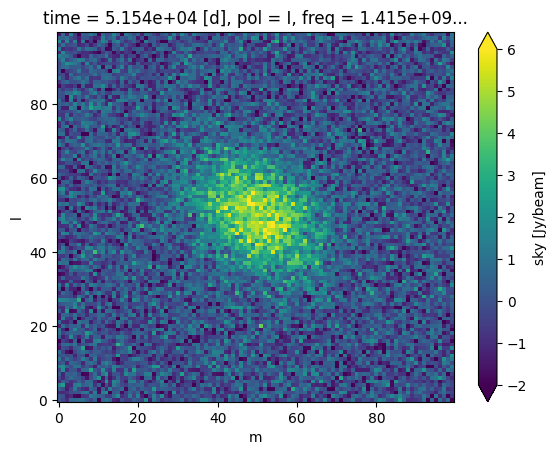

In [43]:
# before region selection, note that we are not using the image pixel mask, mask0, for plotting here.
# This is just a quick and dirty demo; actual ngCASA applications will use pixel masks as expected.
data_sel = {'time': [0], 'pol': [0], 'freq': [0], 'l': slice(50, 150)}
clim = {'vmin': -2, 'vmax': 6}
xds.sky.isel(data_sel).plot(**clim)

Select a circular region of radius 40 pixels .Pixel values in the region outside the center circle are NaN.

In [44]:
l_shift = xds.l - len(xds.l)/2
m_shift = xds.m - len(xds.m)/2
where_sel = xds.where(l_shift**2 + m_shift**2 <= 1600)
where_sel

<xarray.Dataset>
Dimensions:          (time: 1, pol: 4, freq: 50, l: 200, m: 100, beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I' 'Q' 'U' 'V'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Dimensions without coordinates: l, m
Data variables:
    sky              (time, pol, freq, l, m) float64 dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    mask0            (time, pol, freq, l, m) float64 dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    beam             (time, pol, freq, beam_param, l, m) float64 dask.array<chunksize=(1, 4, 50, 3, 200, 100), meta=np.ndarray>
Attributes:
    direction:        {'system': 'FK5', 'equinox': 'J2000', 'conversion_syste...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'refe...
    obsdate:          {'time_scale': 'UTC', 'unit': 'd', 'value': 51544.00000...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

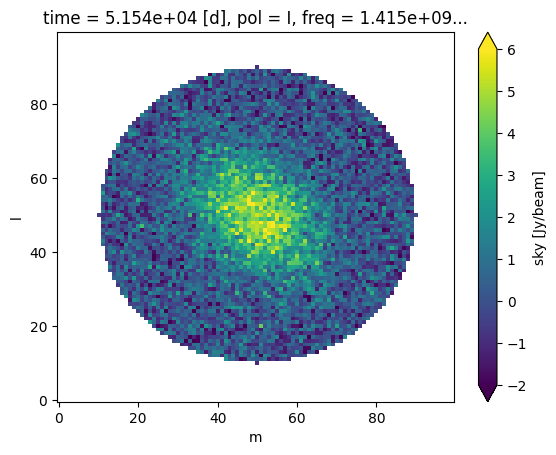

In [45]:
# Here is wha the circular region selection looks like. Pixel values
# outside the selected region are NaN.
where_sel.sky.isel(data_sel).plot(**clim)

With just a little more effort, a Pac Man region can be created.

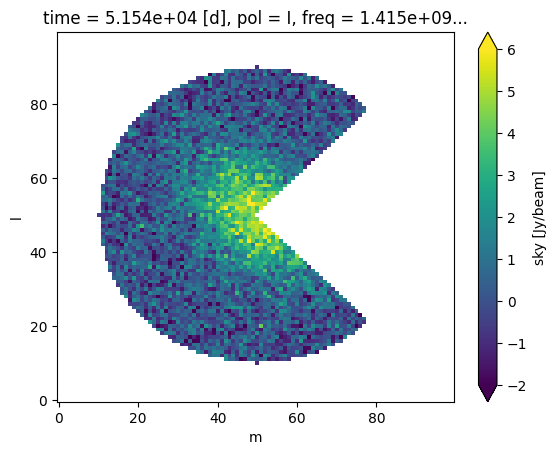

In [46]:
import numpy as np
pacman = where_sel.where(
    np.logical_or(
        np.logical_or(m_shift < 0, l_shift - m_shift > 0),
        l_shift + m_shift < 0
    )
)
pacman.sky.isel(data_sel).plot(**clim)

## Loading a Block of Data Into Memory
In order to process an image's pixel data, it must be loaded into memory. This data must be immediately loaded, so that it cannot be a Dask array. The general architecture is that the loaded data will be placed in a dask.delayed function for processing.

A loaded block of data is itself a valid xds image (it can be correctly thought of as a subimage).

In [47]:
block = load_image(
    'demo_simulated.im', block_des={'time': 0, 'pol': 0, 'freq': slice(0, 10),
    'l': slice(40, 80), 'm': slice(10,20)}
)
block

Successful readonly open of default-locked table demo_simulated.im: 1 columns, 1 rows


<xarray.Dataset>
Dimensions:          (time: 1, pol: 1, freq: 10, l: 40, m: 10, beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.145e+06 1.144e+06
    right_ascension  (l, m) float64 0.01746 0.01746 ... 0.006109 0.006109
    declination      (l, m) float64 -0.01164 -0.01134 ... -0.009309 -0.009018
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Dimensions without coordinates: l, m
Data variables:
    sky              (time, pol, freq, l, m) float32 0.7224 0.1063 ... 0.7738
    mask0            (time, pol, freq, l, m) bool False False ... True False
    beam             (freq, beam_param) float64 0.001454 0.001164 ... 0.3491
Attributes:
    direction:        {'system': 'FK5', 'equinox': 'J2000', 'conversion_syste...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'refe...
    obsdate:          {'time_scale': 'UTC', 'unit': 'd', 'value': 51544.00000...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      
    user:             {}
    active_mask:      mask0
    description:      None
    history:          <xarray.Dataset>\nDimensions:    (row: 15)\nCoordinates...

In [48]:
block.sky

<xarray.DataArray 'sky' (time: 1, pol: 1, freq: 10, l: 40, m: 10)>
array([[[[[ 0.7224022 ,  0.10626119,  0.5598173 , ..., -0.76464635,
            0.5981907 ,  0.913757  ],
          [-0.44877565,  0.22841637, -0.24195498, ...,  0.2669743 ,
            0.8426433 , -0.31074968],
          [ 2.7306864 , -0.28209886,  0.06509547, ..., -0.6499825 ,
            0.54354846, -0.63692975],
          ...,
          [ 0.02142605, -0.72992086, -0.19285776, ...,  0.05930984,
           -1.59042   ,  1.9283288 ],
          [ 0.11547722, -2.2170944 ,  0.0875167 , ...,  2.0453393 ,
           -0.9912556 ,  0.24363595],
          [ 1.418324  ,  0.26966453, -0.85782397, ...,  0.96491003,
           -1.2768915 ,  0.9515328 ]],

         [[-0.5424994 , -0.6993736 ,  1.0196353 , ...,  0.7776511 ,
           -0.2436855 , -0.0551148 ],
          [-0.73127496, -0.64211315,  1.7100253 , ...,  0.57014245,
           -0.03530064,  2.0261304 ],
          [ 0.94702786, -0.6685161 , -0.81777126, ..., -1.6101377 ,
            0.54314154, -1.0483135 ],
...
          [-1.0452551 , -0.8714385 , -0.28769243, ..., -0.9674016 ,
           -0.32775033,  0.7734622 ],
          [-0.20977868, -0.4835554 ,  0.43835372, ..., -0.5335503 ,
            1.9043674 , -0.855564  ],
          [ 0.18020505,  0.11726414,  0.01433355, ...,  0.27176774,
            0.14282393, -1.044748  ]],

         [[-0.23624152, -0.00852353,  0.5867042 , ...,  0.5158534 ,
            1.910625  , -0.16773745],
          [ 0.3931217 , -0.39149985,  1.4439169 , ..., -0.3268005 ,
           -0.09559926, -0.77580404],
          [ 0.7748601 ,  0.16075459, -0.28552178, ..., -0.45159054,
           -1.4363995 ,  2.216285  ],
          ...,
          [-1.4704709 ,  1.6929553 ,  1.6310463 , ...,  1.1242241 ,
           -0.80784345, -0.25346822],
          [ 0.03852313,  0.7703331 , -0.7108183 , ..., -0.03894874,
           -1.3359753 , -0.0044131 ],
          [ 0.4636231 , -0.83200085,  0.15075018, ...,  0.7175111 ,
           -0.80408496,  0.77379864]]]]], dtype=float32)
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.145e+06 1.144e+06
    right_ascension  (l, m) float64 0.01746 0.01746 ... 0.006109 0.006109
    declination      (l, m) float64 -0.01164 -0.01134 ... -0.009309 -0.009018
Dimensions without coordinates: l, m
Attributes:
    image_type:  Intensity
    unit:        Jy/beam

In [49]:
block.mask0

<xarray.DataArray 'mask0' (time: 1, pol: 1, freq: 10, l: 40, m: 10)>
array([[[[[False, False, False, ...,  True, False, False],
          [ True, False,  True, ..., False, False,  True],
          [False,  True, False, ...,  True, False,  True],
          ...,
          [False,  True,  True, ..., False,  True, False],
          [False,  True, False, ..., False,  True, False],
          [False, False,  True, ..., False,  True, False]],

         [[ True,  True, False, ..., False,  True,  True],
          [ True,  True, False, ..., False,  True, False],
          [False,  True,  True, ...,  True, False,  True],
          ...,
          [ True,  True, False, ...,  True,  True, False],
          [False,  True, False, ..., False,  True, False],
          [ True, False, False, ...,  True,  True, False]],

         [[False, False, False, ...,  True, False,  True],
          [False, False, False, ...,  True, False,  True],
          [ True, False, False, ..., False, False, False],
          ...,
...
          ...,
          [False,  True, False, ...,  True, False, False],
          [False, False, False, ..., False, False,  True],
          [False,  True,  True, ..., False, False, False]],

         [[False,  True,  True, ...,  True, False,  True],
          [False,  True,  True, ..., False,  True, False],
          [ True, False, False, ..., False, False,  True],
          ...,
          [ True,  True,  True, ...,  True,  True, False],
          [ True,  True, False, ...,  True, False,  True],
          [False, False, False, ..., False, False,  True]],

         [[ True,  True, False, ..., False, False,  True],
          [False,  True, False, ...,  True,  True,  True],
          [False, False,  True, ...,  True,  True, False],
          ...,
          [ True, False, False, ..., False,  True,  True],
          [False, False,  True, ...,  True,  True,  True],
          [False,  True, False, ..., False,  True, False]]]]])
Coordinates:
  * time             (time) float64 5.154e+04
  * pol              (pol) <U1 'I'
  * freq             (freq) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    vel              (freq) float64 1.146e+06 1.146e+06 ... 1.145e+06 1.144e+06
    right_ascension  (l, m) float64 0.01746 0.01746 ... 0.006109 0.006109
    declination      (l, m) float64 -0.01164 -0.01134 ... -0.009309 -0.009018
Dimensions without coordinates: l, m
Attributes:
    image_type:  Mask

A numpy.ma.masked_array can be created from the pixels and the mask

In [50]:
import numpy as np

ma = np.ma.masked_array(block.sky[:], block.mask0[:])
ma

masked_array(
  data=[[[[[0.7224022150039673, 0.10626118630170822,
            0.5598173141479492, ..., --, 0.5981907248497009,
            0.9137570261955261],
           [--, 0.22841636836528778, --, ..., 0.2669743001461029,
            0.8426433205604553, --],
           [2.7306864261627197, --, 0.06509546935558319, ..., --,
            0.5435484647750854, --],
           ...,
           [0.02142605371773243, --, --, ..., 0.05930984392762184, --,
            1.9283287525177002],
           [0.11547721922397614, --, 0.08751670271158218, ...,
            2.045339345932007, --, 0.24363595247268677],
           [1.4183239936828613, 0.2696645259857178, --, ...,
            0.9649100303649902, --, 0.951532781124115]],

          [[--, --, 1.0196353197097778, ..., 0.7776510715484619, --,
            --],
           [--, --, 1.7100253105163574, ..., 0.5701424479484558, --,
            2.026130437850952],
           [0.947027862071991, --, --, ..., --, 0.5431415438652039,
            --],
  

Now the masked array can be put in a dask.delayed function, and things can be done with it.

In [51]:
import dask.delayed

def compute_sum(ary):
    return np.sum(ary)

summer = dask.delayed(compute_sum)(ma)
print('summer type', type(summer))

mysum = summer.compute()
mysum

summer type <class 'dask.delayed.Delayed'>


1592.3501

## Convert an xds image to a CASA image

In [52]:
# force arrays into a single chunk so writing doesn't take forever
xds = xds.chunk('auto')
write_image(xds, 'new_casa.im', out_format='casa')

In [53]:
from casacore.images import image as cimage
myim = cimage('new_casa.im')
ia_orig = cimage(imname)

The original image has axes in RA, Dec, Freq, Stokes order. Conversion of an xds image XDS
to a casa image results in a casacore image with axes in the order tclean currently writes,
RA, Dec, Stokes, Freq, so we must transpose the pixel values of one to compare to the pixel
values of the other. And the python-casacore image methods usually access pixels in the
reverse order you would expect.

In [54]:
(myim.getdata() == ia_orig.getdata().transpose(1, 0, 2, 3)).all()

True

In [ ]:
got = myim.statistics()
del got['minpos'], got['maxpos']
exp = ia_orig.statistics()
del exp['minpos'], exp['maxpos']
for k in exp.keys():
    print(k, np.isclose(got[k][0], exp[k][0]))

In [ ]:
(myim.getmask() == ia_orig.getmask().transpose(1, 0, 2, 3)).all()

In [ ]:
del myim
del ia_orig